# Machine Learning Analysis - London Housing Data

This notebook will apply supervised ML models from scikit-learn to analyse the real estate data in ```10m_london_houses_.csv```.

Exploratory data analysis of this dataset is covered in ```EDA.ipynb```.

The goal of this notebook is to try out some simple ML models and test best ML practices using a straightforward dataset. This includes
- Apply regression models (Linear, Ridge and Lasso) to predict house prices.
- Perform k-fold cross validation.
- Evaluate model performance with all available metrics: ROC/ AUC curves, accuracy, precision, F1-score, R^2, MSE, RMSE, NMSE confusion matrices.
- Perform hyperparameter tuning with GridSearchCV and RandomSearchCV to optimize models.
- Determine the best regression model for price prediction.
- Convert categorical data to numerical data.
- Evaluate the effect of scaling/ normalization on model performance.
- Automate model building with pipelines.
- Principal component analysis - [Geeksforgeeks](https://www.geeksforgeeks.org/data-analysis/principal-component-analysis-with-python/)

Repository link: [Github](https://github.com/rsamconn/London-housing)

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print(np.NaN)

nan


In [2]:
# Load the data
housing_df = pd.read_csv('data/10m_london_houses_.csv')

# Reminder of how the data looks
print(f"Dataset shape: {housing_df.shape}")
display(housing_df.head())

Dataset shape: (1000, 17)


,Address,Neighborhood,Bedrooms,Bathrooms,Square Meters,Building Age,Garden,Garage,Floors,Property Type,Heating Type,Balcony,Interior Style,View,Materials,Building Status,Price (£)
0,78 Regent Street,Notting Hill,2,3,179,72,No,No,3,Semi-Detached,Electric Heating,High-level Balcony,Industrial,Garden,Marble,Renovated,2291200
1,198 Oxford Street,Westminster,2,1,123,34,Yes,No,1,Apartment,Central Heating,High-level Balcony,Industrial,City,Laminate Flooring,Old,1476000
2,18 Regent Street,Soho,5,3,168,38,No,Yes,3,Semi-Detached,Central Heating,No Balcony,Industrial,Street,Wood,Renovated,1881600
3,39 Piccadilly Circus,Islington,5,1,237,53,Yes,Yes,1,Apartment,Underfloor Heating,No Balcony,Classic,Park,Granite,Renovated,1896000
4,116 Fleet Street,Marylebone,4,1,127,23,No,Yes,2,Semi-Detached,Central Heating,No Balcony,Modern,Park,Wood,Old,1524000


## Planning

I will run Regression models for several different 'passes' which each use different feature datasets.

Each pass gets these steps:

1. Determine input data
2. Import, instantiate, and fit models - linear, lasso, ridge
3. Predicting target variables
4. Evaluating predictions vs. test data
5. K-fold cross validation
6. Hyperparameter tuning
7. Pipeline for best model

Afterwards I can do more advanced things - scaling, categorical -> numeric, other metrics, PCA

Input data ideas:

- [x] Pass 1 = only square meters
- [] Pass 2 = only numeric data
- [] Pass 3 = numeric data plus some categoric data converted to numeric - only the Neighborhood column
- [] Intermediate run = numeric data plus some categoric data converted to numeric - only those columns which are T/F
- [] Final run through = _all_ data

Other ideas: add price per square meter column, add other features?

In [3]:
from sklearn.model_selection import train_test_split

# Import models
from sklearn.linear_model import LinearRegression, Lasso, Ridge

## -------------------- Pass 1 - Only Square Meters --------------------
1. Get data
2. Simple test models - pick 1 hyperparam, instantiate, fit, score, predict and plot predictions
3. k-fold cross validation - setup k-Fold data, apply `cross_val_score`, boxplot the results
4. Hyperparameter tuning - setup param grids, setup RandomizedSearchCV object, fit, print score, best score and best params

### 1.1 Get data

In [4]:
# Create sqm-only dataset
X_sqm = housing_df['Square Meters'].values.reshape(-1, 1)
y = housing_df['Price (£)'].values
X_train_sqm, X_test_sqm, y_train_sqm, y_test_sqm = train_test_split(X_sqm, y, test_size=0.3, random_state=24)

print(X_train_sqm.shape, X_test_sqm.shape, y_train_sqm.shape, y_test_sqm.shape)

(700, 1) (300, 1) (700,) (300,)


### 1.2 Simple models

#### 1.2.1 Instantiate and fit

In [5]:
# Instantiate models
linreg1 = LinearRegression()
lasso1 = Lasso(alpha = 0.1)
ridge1 = Ridge(alpha = 0.1)

# Fit to numeric data
linreg1.fit(X_train_sqm, y_train_sqm)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [6]:
lasso1.fit(X_train_sqm, y_train_sqm)


,alpha,0.1
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [7]:
ridge1.fit(X_train_sqm, y_train_sqm)

,alpha,0.1
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [8]:
# Create a model dictionary
models_sqm = {
    'Linear Regression': linreg1,
    'Lasso': lasso1,
    'Ridge': ridge1
}

#### 1.2.2 Predict and plot

In [9]:
def score_predict_plot(model_dict, X_test, y_test, X_test1D, title='Model predictions'):
    """Evaluate multiple models and plot their predictions vs actual values."""
    
    # Create figure and plot the actual results
    plt.figure(figsize=(10, 6))
    plt.scatter(X_test1D, y_test, label='Actual', color='black', alpha=0.9, s=20)
    
    # Loop over models and plot their restults
    for model_name, model in model_dict.items():
        # Generate predictions
        y_pred = model.predict(X_test)
        # Print model score
        print(f"{model_name} Score (R²): {model.score(X_test, y_test):.4f}")
        # Scatter plot predictions vs actual
        plt.scatter(X_test1D, y_pred, label=model_name, alpha=0.5, s=20)
        
    # Labels and title
    plt.xlabel('X test', fontsize=11)
    plt.ylabel('Target results [£]', fontsize=11)
    plt.title(title, fontsize=12, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

Linear Regression Score (R²): 0.5912
Lasso Score (R²): 0.5912
Ridge Score (R²): 0.5912


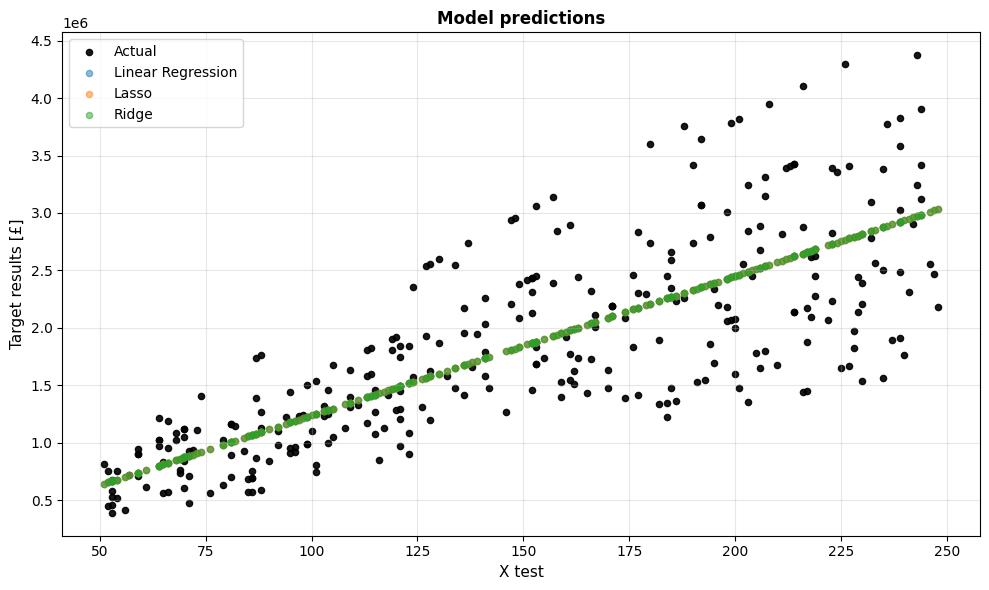

In [10]:
score_predict_plot(models_sqm, X_test_sqm, y_test_sqm, X_test_sqm)

### 1.3 Cross validation

- Create a k-fold dataset
- Fit and print min-mean-max
- Boxplot the results

In [11]:
# Create k-fold object
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
kf5 = KFold(n_splits=5, shuffle=True, random_state=24)
kf10 = KFold(n_splits=10, shuffle=True, random_state=24)

In [14]:
def multi_cross_val_score(models, X, y, kf):
    """Function to return cross-validation scores for multiple models."""
    cross_val_scores = {}
    for name, model in models.items():
        scores = cross_val_score(model, X, y, cv=kf)
        cross_val_scores[name] = scores
        print(f'{name} cross-validation scores: {np.round(np.min(scores), 3)} --- {np.round(np.mean(scores), 3)} --- {np.round(np.max(scores), 3)}')
    return cross_val_scores

In [35]:
cross_vals_sqm = multi_cross_val_score(
    models = {'Linear Regression': linreg1, 'Lasso': lasso1, 'Ridge': ridge1},
    X = X_train_sqm,
    y = y_train_sqm,
    kf = kf10
)

Linear Regression cross-validation scores: 0.526 --- 0.63 --- 0.698
Lasso cross-validation scores: 0.526 --- 0.63 --- 0.698
Ridge cross-validation scores: 0.526 --- 0.63 --- 0.698


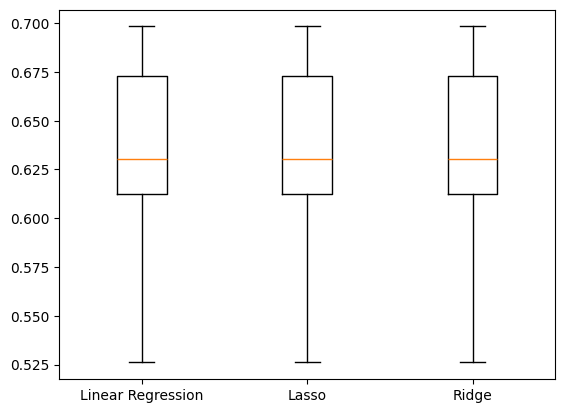

In [16]:
plt.boxplot(
    [model_result for model_result in cross_vals_sqm.values()],
    labels = [model_name for model_name in cross_vals_sqm.keys()]
)
plt.show()

### 1.4 Hyperparameter tuning

In [18]:
lasso_params = {'alpha': np.linspace(0.001, 10)}
ridge_params = {'alpha': np.linspace(0.001, 10),
                'solver': ['sag', 'lsqr']}

#### 1.4.1 GridSearchCV
Instantiate and fit

In [19]:
# Instantiate GridSearchCVs
gridCV_lasso1 = GridSearchCV(lasso1, lasso_params, cv=kf10)
gridCV_ridge1 = GridSearchCV(ridge1, ridge_params, cv=kf10)
# Fit GridSearchCVs
gridCV_lasso1.fit(X_train_sqm, y_train_sqm)
gridCV_ridge1.fit(X_train_sqm, y_train_sqm)

,estimator,Ridge(alpha=0.1)
,param_grid,"{'alpha': array([1.0000...00000000e+01]), 'solver': ['sag', 'lsqr']}"
,scoring,None
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,6.53095918367347


Score

In [20]:
# Basic scoring - GridSearchCV models
print(f'Lasso score: {gridCV_lasso1.score(X_test_sqm, y_test_sqm)}')
print(f'Ridge score: {gridCV_ridge1.score(X_test_sqm, y_test_sqm)}')
# Best parameters and scores - GridSearchCV models
print(f'Lasso GridSearchCV top score: {gridCV_lasso1.best_score_} from {gridCV_lasso1.best_params_}')
print(f'Ridge GridSearchCV top score: {gridCV_ridge1.best_score_} from {gridCV_ridge1.best_params_}')

Lasso score: 0.5912280150046298
Ridge score: 0.5912279224375068
Lasso GridSearchCV top score: 0.6295668661897607 from {'alpha': 10.0}
Ridge GridSearchCV top score: 0.630208200684607 from {'alpha': 6.53095918367347, 'solver': 'sag'}


#### 1.4.2 RandomSearchCV

In [21]:
# Instantiate RandomizedSearchCVs
randomCV_lasso1 = RandomizedSearchCV(lasso1, lasso_params, cv=kf10, n_iter=10, random_state=24)
randomCV_ridge1 = RandomizedSearchCV(ridge1, ridge_params, cv=kf10, n_iter=10, random_state=24)
# Fit RandomizedSearchCVs
randomCV_lasso1.fit(X_train_sqm, y_train_sqm)
randomCV_ridge1.fit(X_train_sqm, y_train_sqm)

,estimator,Ridge(alpha=0.1)
,param_distributions,"{'alpha': array([1.0000...00000000e+01]), 'solver': ['sag', 'lsqr']}"
,n_iter,10
,scoring,None
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,24
,error_score,nan


Score

In [22]:
# Scoring - RandomizedSearchCV models
# Lasso
print(f'Lasso score: {randomCV_lasso1.score(X_test_sqm, y_test_sqm)}')
print(f'Lasso RandomizedSearchCV top score: {randomCV_lasso1.best_score_} from {randomCV_lasso1.best_params_}')
# Ridge
print(f'Ridge score: {randomCV_ridge1.score(X_test_sqm, y_test_sqm)}')
print(f'Ridge RandomizedSearchCV top score: {randomCV_ridge1.best_score_} from {randomCV_ridge1.best_params_}')

Lasso score: 0.5912280122165263
Lasso RandomizedSearchCV top score: 0.6295668652544718 from {'alpha': 8.163448979591838}
Ridge score: 0.5912236575171832
Ridge RandomizedSearchCV top score: 0.629602663664361 from {'solver': 'sag', 'alpha': 8.775632653061225}


### 1.5 Scaling
Can the score be increased through Standard Scaling?

In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

steps_sqm = [
    ('scaler', StandardScaler()),
    ('ridge', Ridge()),
]

pipeline_ridge1 = Pipeline(steps_sqm)

ridge1_scaled = pipeline_ridge1.fit(X_train_sqm, y_train_sqm)

In [25]:
ridge1_scaled.score(X_test_sqm, y_test_sqm)

0.5913154197136332

Adding in CVs

In [26]:
lasso_params2 = {'alpha': np.linspace(0.0001, 1, 10)}
ridge_params2 = {'ridge__alpha': np.linspace(0.0001, 1, 10),
                'ridge__solver': ['sag', 'lsqr']}

In [27]:
# Instantiate GridSearchCVs
gridCV_ridge1_scaled = GridSearchCV(ridge1_scaled, param_grid=ridge_params2, cv=kf10)
# Fit GridSearchCVs
gridCV_ridge1_scaled.fit(X_train_sqm, y_train_sqm)

# Score GridSearchCV models
print(f'Ridge score: {gridCV_ridge1_scaled.score(X_test_sqm, y_test_sqm)}')
print(f'Scaled Ridge GridSearchCV top score: {gridCV_ridge1_scaled.best_score_} from {gridCV_ridge1_scaled.best_params_}')

Ridge score: 0.5912496406785134
Scaled Ridge GridSearchCV top score: 0.6296287322352787 from {'ridge__alpha': 0.11120000000000001, 'ridge__solver': 'sag'}


### 1.6 Pass 1 - what have we learned?

1. Simple models: each of Linear, Lasso and Ridge Regression each get 59% accuracy --> Quite poor
    - Each model seems to be making exactly the same predictions
2. 5-Fold cross-validation: the scores range from 59-66% (average 63%)
3. 10-Fold cross-validation: the scores range from 53-70% (average 63%)
4. GridSearchCV over alpha: best parameters get 63% at alpha=1 (Ridge and Lasso are equal, RandomizedSearchCV gives basically the same results)
5. Nothing gained from scaling

## -------------------- Pass 2 - Numeric data --------------------
Now include the numbers of bedrooms, bathrooms, floors and the building age in the feature set.

### 2.1 Get Data

In [28]:
# Create numeric-only dataset
numeric_columns = ['Bedrooms', 'Bathrooms', 'Square Meters', 'Building Age', 'Floors']
X_numeric = housing_df.loc[:, numeric_columns].values
y = housing_df['Price (£)'].values
X_train_numeric, X_test_numeric, y_train_numeric, y_test_numeric = train_test_split(X_numeric, y, test_size=0.3, random_state=24)

print(X_train_numeric.shape, X_test_numeric.shape, y_train_numeric.shape, y_test_numeric.shape)

(700, 5) (300, 5) (700,) (300,)


### 2.2 Simple Models

#### 2.2.1 Import, instantiate, fit

Linear, lasso and ridge regression model

In [29]:
# Instantiate models
linreg_num = LinearRegression()
lasso_num = Lasso(alpha = 0.1)
ridge_num = Ridge(alpha = 0.1)

# Fit to numeric data
linreg_num.fit(X_train_numeric, y_train_numeric)
lasso_num.fit(X_train_numeric, y_train_numeric)
ridge_num.fit(X_train_numeric, y_train_numeric)

,alpha,0.1
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [30]:
# Create a dictionary of numeric models
models_numeric = {
    'Linear Regression': linreg_num,
    'Lasso': lasso_num,
    'Ridge': ridge_num
}

#### 2.2.3 Predict

Linear Regression Score (R²): 0.5901
Lasso Score (R²): 0.5901
Ridge Score (R²): 0.5901


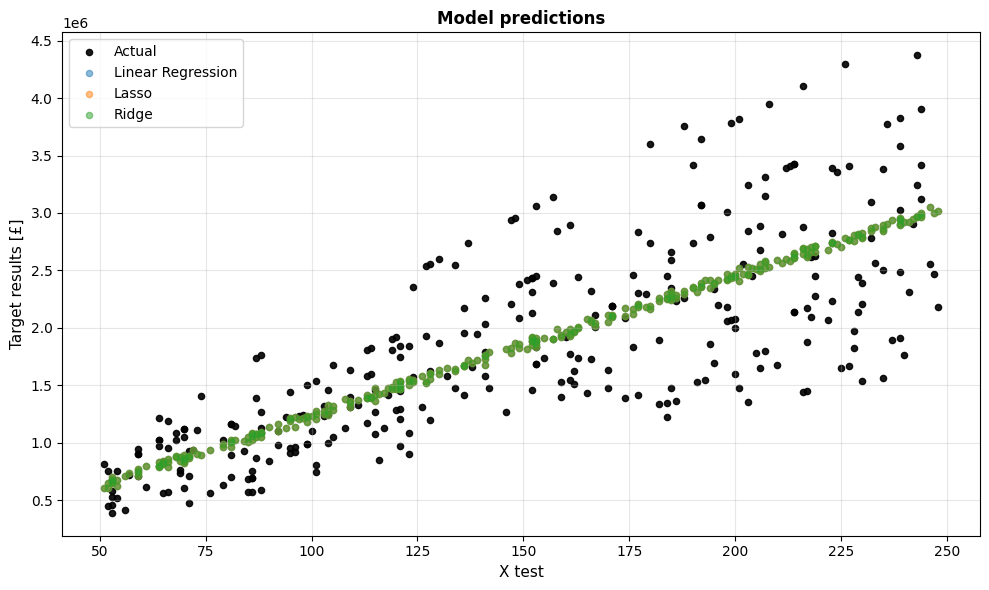

In [31]:
score_predict_plot(models_numeric, X_test_numeric, y_test_numeric, X_test_sqm)

## 2.3 Cross validation - Numeric

- Create a k-fold dataset
- Fit and print min-mean-max
- Boxplot the results

In [34]:
cross_vals_num = multi_cross_val_score(
    models = models_numeric,
    X = X_train_numeric,
    y = y_train_numeric,
    kf = kf10
)

Linear Regression cross-validation scores: 0.526 --- 0.627 --- 0.698
Lasso cross-validation scores: 0.526 --- 0.627 --- 0.698
Ridge cross-validation scores: 0.526 --- 0.627 --- 0.698


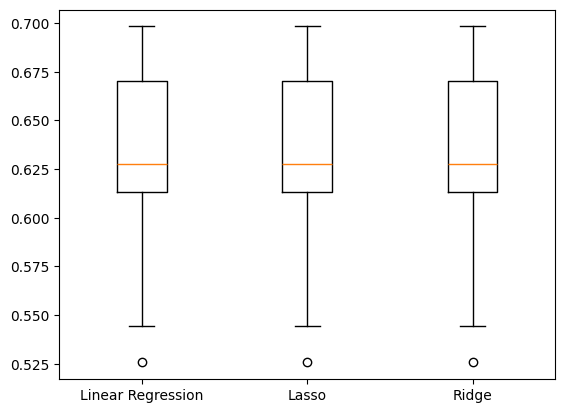

In [36]:
plt.boxplot(
    [model_result for model_result in cross_vals_num.values()],
    labels = [model_name for model_name in cross_vals_num.keys()]
)
plt.show()

### 2.4 Hyperparameter Tuning - Numeric

#### 2.4.1 GridSearchCV
Instantiate and fit

In [44]:
lasso_params2 = {'alpha': np.linspace(0.001, 100, 20)}
ridge_params2 = {'alpha': np.linspace(0.001, 100, 20),
                'solver': ['sag', 'lsqr']}

In [45]:
# Instantiate GridSearchCVs
gridCV_lasso_num = GridSearchCV(lasso1, lasso_params2, cv=kf10)
gridCV_ridge_num = GridSearchCV(ridge1, ridge_params2, cv=kf10)
# Fit GridSearchCVs
gridCV_lasso_num.fit(X_train_numeric, y_train_numeric)
gridCV_ridge_num.fit(X_train_numeric, y_train_numeric)

,estimator,Ridge(alpha=0.1)
,param_grid,"{'alpha': array([1.0000...00000000e+02]), 'solver': ['sag', 'lsqr']}"
,scoring,None
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,100.0


Score

In [46]:
# Basic scoring - GridSearchCV models
print(f'Lasso score: {gridCV_lasso_num.score(X_test_numeric, y_test_numeric)}')
print(f'Ridge score: {gridCV_ridge_num.score(X_test_numeric, y_test_numeric)}')
# Best parameters and scores - GridSearchCV models
print(f'Lasso GridSearchCV top score: {gridCV_lasso_num.best_score_} from {gridCV_lasso_num.best_params_}')
print(f'Ridge GridSearchCV top score: {gridCV_ridge_num.best_score_} from {gridCV_ridge_num.best_params_}')

Lasso score: 0.5901066976229288
Ridge score: 0.5905246630679386
Lasso GridSearchCV top score: 0.6267405996993188 from {'alpha': 100.0}
Ridge GridSearchCV top score: 0.6271186203362442 from {'alpha': 100.0, 'solver': 'lsqr'}


#### 2.4.2 RandomSearchCV

In [52]:
# Instantiate RandomizedSearchCVs
randomCV_lasso_num = RandomizedSearchCV(lasso_num, lasso_params2, cv=kf10, n_iter=20, random_state=24)
randomCV_ridge_num = RandomizedSearchCV(ridge_num, ridge_params2, cv=kf10, n_iter=20, random_state=24)
# Fit RandomizedSearchCVs
randomCV_lasso_num.fit(X_train_numeric, y_train_numeric)
randomCV_ridge_num.fit(X_train_numeric, y_train_numeric)

,estimator,Ridge(alpha=0.1)
,param_distributions,"{'alpha': array([1.0000...00000000e+02]), 'solver': ['sag', 'lsqr']}"
,n_iter,20
,scoring,None
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,24
,error_score,nan


Score

In [53]:
# Scoring - RandomizedSearchCV models
# Lasso
print(f'Lasso score: {randomCV_lasso_num.score(X_test_numeric, y_test_numeric)}')
print(f'Lasso RandomizedSearchCV top score: {randomCV_lasso_num.best_score_} from {randomCV_lasso_num.best_params_}')
# Ridge
print(f'Ridge score: {randomCV_ridge_num.score(X_test_numeric, y_test_numeric)}')
print(f'Ridge RandomizedSearchCV top score: {randomCV_ridge_num.best_score_} from {randomCV_ridge_num.best_params_}')

Lasso score: 0.5901066976229288
Lasso RandomizedSearchCV top score: 0.6267405996993188 from {'alpha': 100.0}
Ridge score: 0.5905246630679386
Ridge RandomizedSearchCV top score: 0.6271186203362442 from {'solver': 'lsqr', 'alpha': 100.0}


### 2.5 Scaling - numeric data

In [55]:
steps_numeric = [
    ('scaler', StandardScaler()),
    ('ridge', Ridge()),
]

pipeline_ridge_num = Pipeline(steps_numeric)

ridge_num_scaled = pipeline_ridge_num.fit(X_train_numeric, y_train_numeric)

In [56]:
ridge_num_scaled.score(X_test_numeric, y_test_numeric)

0.5901869473795919

In [58]:
# Create a RandomizedSearchCV with pipelines
ridge_num_params = {'ridge__alpha': np.linspace(0.0001, 1, 100),
                         'ridge__solver': ['sag', 'lsqr']}
randomCV_ridge_num_scaled = RandomizedSearchCV(pipeline_ridge_num, param_distributions=ridge_num_params, cv=kf10, n_iter=20, random_state=24)

randomCV_ridge_num_scaled.fit(X_train_numeric, y_train_numeric)

,estimator,"Pipeline(step...e', Ridge())])"
,param_distributions,"{'ridge__alpha': array([1.000e...1, 1.000e+00]), 'ridge__solver': ['sag', 'lsqr']}"
,n_iter,20
,scoring,None
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,24
,error_score,nan


In [59]:
# Score RandomizedSearchCV models
print(f'Ridge score: {randomCV_ridge_num_scaled.score(X_test_numeric, y_test_numeric)}')
print(f'Scaled Ridge GridSearchCV top score: {randomCV_ridge_num_scaled.best_score_} from {randomCV_ridge_num_scaled.best_params_}')

Ridge score: 0.5901854570208226
Scaled Ridge GridSearchCV top score: 0.6267771274794838 from {'ridge__solver': 'lsqr', 'ridge__alpha': 0.9899}


### 2.6 PCA with Lasso
Plot the importance of different features with Lasso Regression.

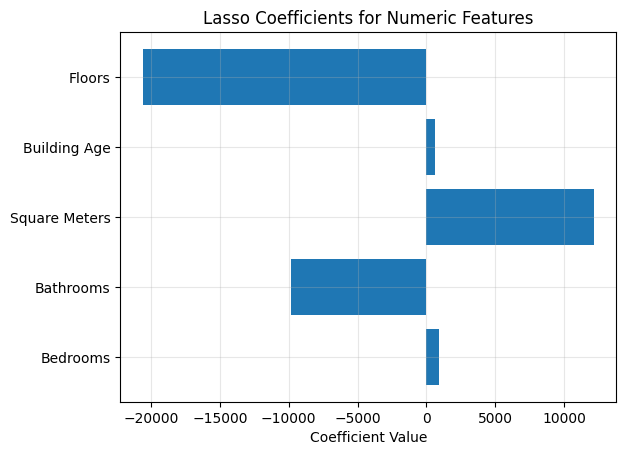

In [61]:
lasso_coeff1 = lasso_num.fit(X_train_numeric, y_train_numeric).coef_

lasso_coeff1

plt.barh(numeric_columns, lasso_coeff1)
plt.xlabel('Coefficient Value')
plt.title('Lasso Coefficients for Numeric Features')
plt.grid(True, alpha=0.3)
plt.show()

Lasso feature decomposition after scaling

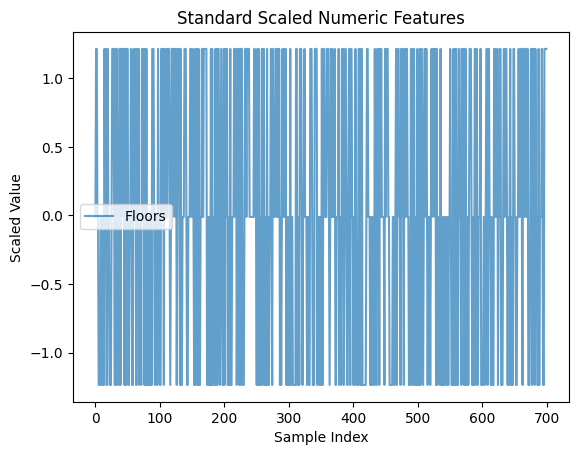

In [78]:
scaler1 = StandardScaler()
scaled_data1 = scaler1.fit_transform(X_train_numeric)

PCA after scaling

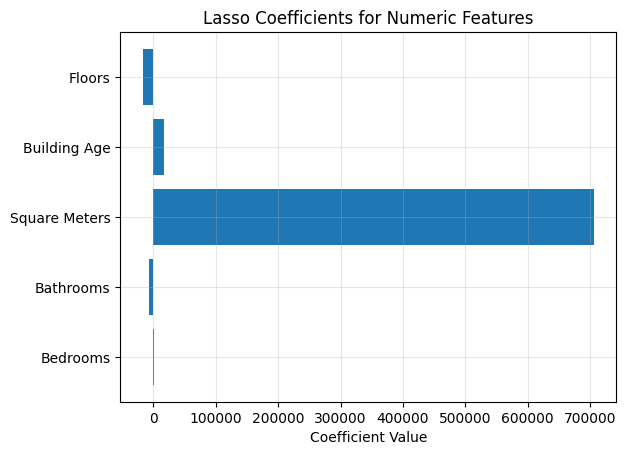

In [79]:
lasso_coeff2 = lasso_num.fit(scaled_data1, y_train_numeric).coef_

lasso_coeff2

plt.barh(numeric_columns, lasso_coeff2)
plt.xlabel('Coefficient Value')
plt.title('Lasso Coefficients for Numeric Features')
plt.grid(True, alpha=0.3)
plt.show()

### 2.7 Summary
1. Simple models - same performance as when using just Square Meters.
2. Cross-validation - same performance as...
3. Hyperparameter tuning - same performance as...
4. Scaling - nothing gained
5. PCA - as expected Square Meters has the biggest effect after scaling (if you don't apply scaling then floors and bathrooms have massive negative coefficients).
6. Lasso, Ridge and LinReg still all the same

## -------------------- Pass 3 - Adding Neighbourhood data --------------------
As well as the numeric data, we now add categoric data: the neighbourhood of each house.

This requires converting the categoric data to numeric data.

This is expected to improve accuracy - from the EDA, the neighbourhoods were quite strongly correlated to the Price.

In [80]:
# Print the columns of the full dataset
print(housing_df.columns)

Index(['Address', 'Neighborhood', 'Bedrooms', 'Bathrooms', 'Square Meters',
       'Building Age', 'Garden', 'Garage', 'Floors', 'Property Type',
       'Heating Type', 'Balcony', 'Interior Style', 'View', 'Materials',
       'Building Status', 'Price (£)'],
      dtype='object')
